# Zillow Regression Project: Estimating Home Value

In [33]:
#import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# https://seaborn.pydata.org/tutorial/color_palettes.html
# https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html

# set seaborn color palette
sns.color_palette("crest")
pal = sns.set_palette('crest')

# import models
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import explained_variance_score

from sklearn.linear_model import TweedieRegressor

import sklearn.feature_selection as feat_select
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#import custom functions
import acquire
#import prepare
#import explore
import wrangle

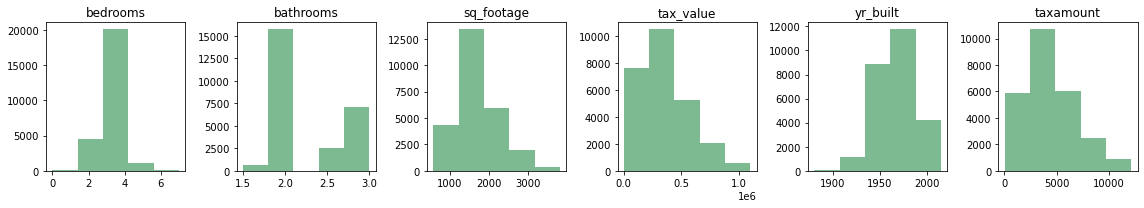

In [2]:
df = wrangle.wrangle_zillow()

In [3]:
df.head()

bedrooms  bathrooms  sq_footage  tax_value  yr_built  taxamount    fips  \
0       3.0        2.0      1772.0   418763.0    1978.0    4464.42  6111.0   
1       3.0        2.0      1819.0   478430.0    1981.0    5515.94  6111.0   
3       2.0        2.0      1503.0   171687.0    1933.0    2287.55  6037.0   
4       4.0        2.0      1604.0   498347.0    1950.0    6089.82  6037.0   
5       3.0        3.0      2384.0   549917.0    1937.0    6679.55  6037.0   

   propertylandusetypeid        propertylandusedesc  
0                  261.0  Single Family Residential  
1                  261.0  Single Family Residential  
3                  261.0  Single Family Residential  
4                  261.0  Single Family Residential  
5                  261.0  Single Family Residential

In [4]:
df.shape

(26038, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26038 entries, 0 to 37545
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bedrooms               26038 non-null  float64
 1   bathrooms              26038 non-null  float64
 2   sq_footage             26038 non-null  float64
 3   tax_value              26038 non-null  float64
 4   yr_built               26038 non-null  float64
 5   taxamount              26038 non-null  float64
 6   fips                   26038 non-null  float64
 7   propertylandusetypeid  26038 non-null  float64
 8   propertylandusedesc    26038 non-null  object 
dtypes: float64(8), object(1)
memory usage: 2.0+ MB


In [6]:
df.isna().sum()

bedrooms                 0
bathrooms                0
sq_footage               0
tax_value                0
yr_built                 0
taxamount                0
fips                     0
propertylandusetypeid    0
propertylandusedesc      0
dtype: int64

In [7]:
df[df.duplicated()]

Empty DataFrame
Columns: [bedrooms, bathrooms, sq_footage, tax_value, yr_built, taxamount, fips, propertylandusetypeid, propertylandusedesc]
Index: []

In [8]:
print("Mean of bedrooms:",df.bedrooms.mean())
print("Mean of bathrooms:", df.bathrooms.mean())
print("Mean of square footage:",df.sq_footage.mean())
print("Mean of tax value : ", df.tax_value.mean())
print("Mean of yr built:", df.yr_built.mean())
print("Mean of tax amount:", df.taxamount.mean())

Mean of bedrooms: 3.208464551808895
Mean of bathrooms: 2.3112566249327906
Mean of square footage: 1710.8092787464475
Mean of tax value :  357156.5054151625
Mean of yr built: 1967.5008833243721
Mean of tax amount: 4389.236371457098


In [9]:
df.apply(wrangle.minMax)

bedrooms  bathrooms  sq_footage  tax_value  yr_built  taxamount    fips  \
min       0.0        1.5       576.0      100.0    1880.0      49.18  6037.0   
max       7.0        3.0      3804.0  1101116.0    2015.0   12137.26  6111.0   

     propertylandusetypeid propertylandusedesc  
min                  261.0        Cluster Home  
max                  266.0           Townhouse

array([[<AxesSubplot:title={'center':'fips'}>]], dtype=object)

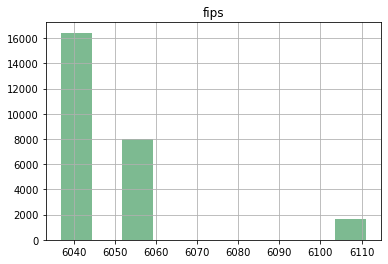

In [10]:
df.hist('fips')

In [11]:
df.fips.value_counts()

6037.0    16430
6059.0     7972
6111.0     1636
Name: fips, dtype: int64

array([[<AxesSubplot:title={'center':'propertylandusetypeid'}>]],
      dtype=object)

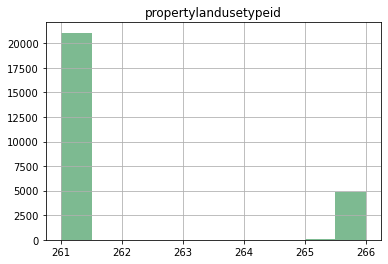

In [12]:
df.hist('propertylandusetypeid')

In [13]:
df.propertylandusetypeid.value_counts()

261.0    21067
266.0     4846
265.0       96
263.0       27
264.0        2
Name: propertylandusetypeid, dtype: int64

In [14]:
df.bathrooms.value_counts()

2.0    15700
3.0     7125
2.5     2586
1.5      627
Name: bathrooms, dtype: int64

In [15]:
df.bedrooms.value_counts()

3.0    12566
4.0     7537
2.0     4475
5.0     1172
1.0      166
6.0      106
7.0       12
0.0        4
Name: bedrooms, dtype: int64

In [16]:
df.sq_footage.mean()

1710.8092787464475

In [17]:
df.sq_footage.min()

576.0

In [18]:
df.sq_footage.max()

3804.0

In [19]:
#Split data into train, validate and test datasets to prepare for exploration
train, validate, test = wrangle.split_data(df)
train.shape, validate.shape, test.shape

((14581, 9), (6249, 9), (5208, 9))

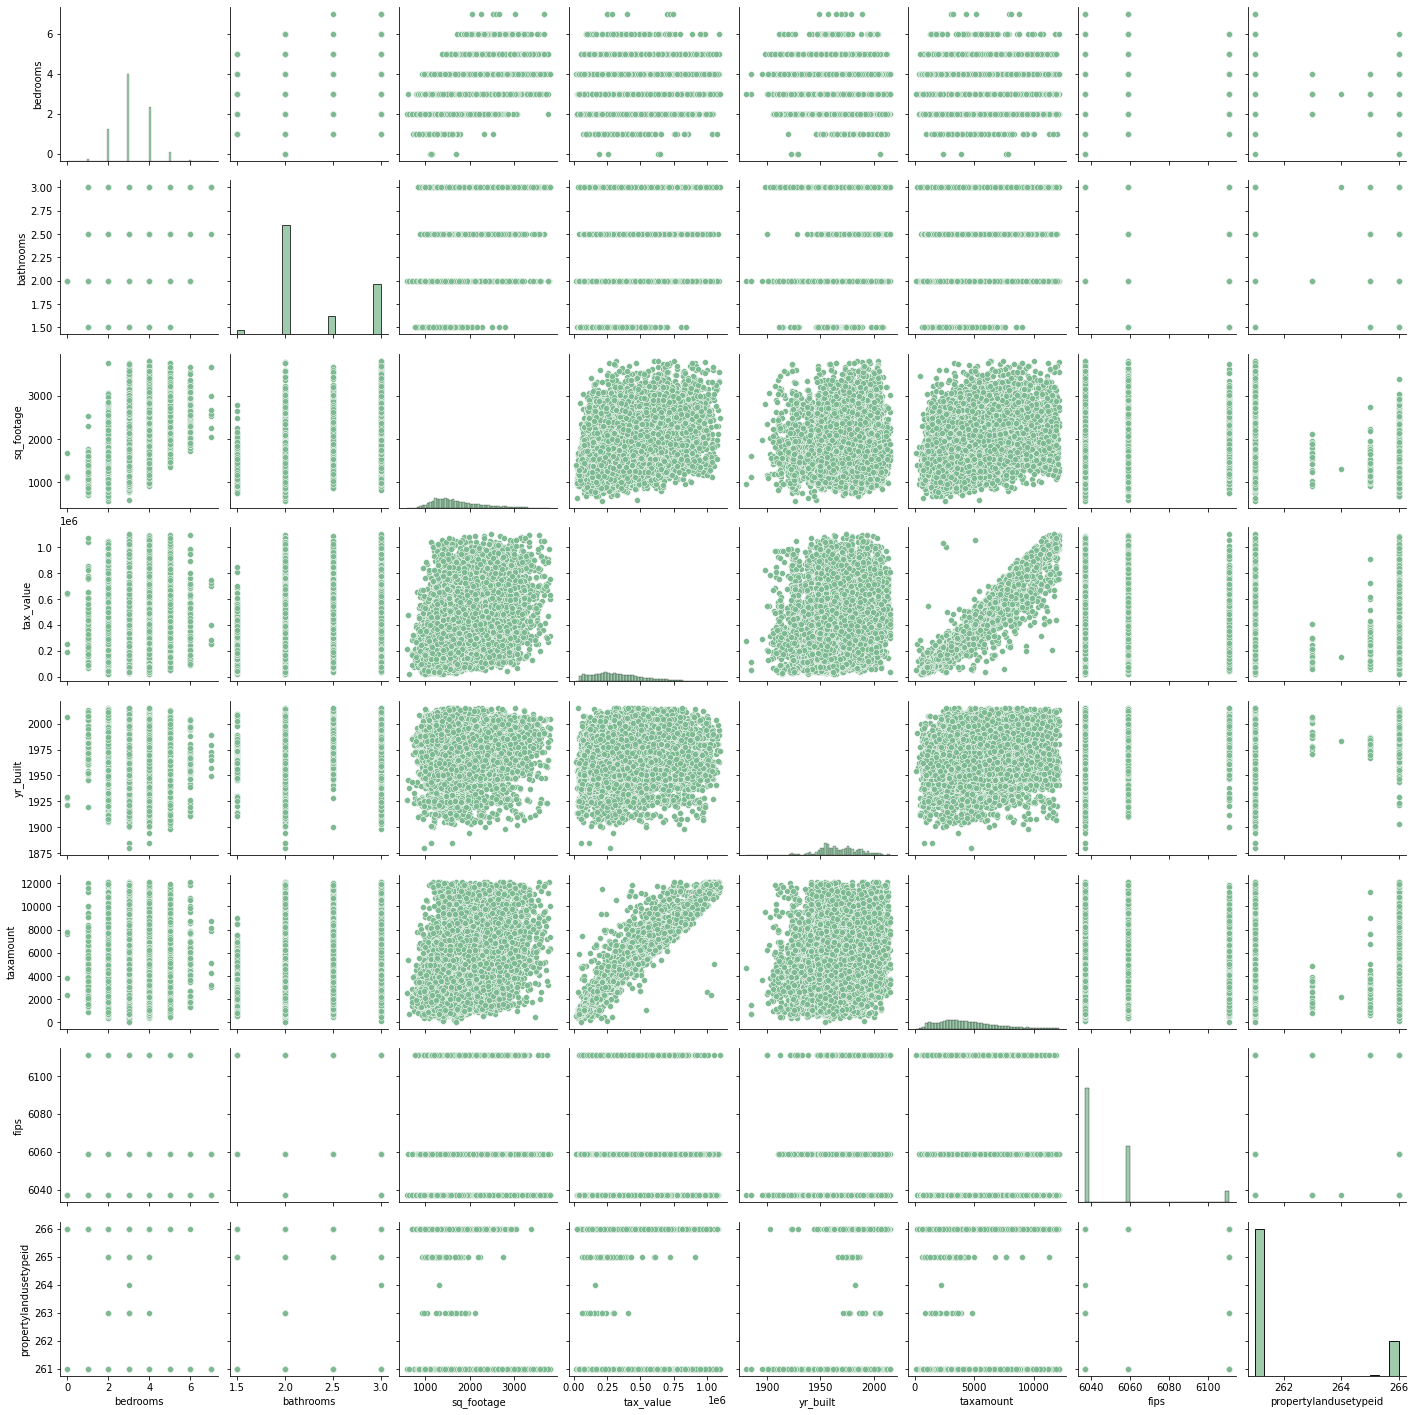

In [20]:
sns.pairplot(train)

In [21]:
train.groupby('bedrooms').bathrooms.mean()

bedrooms
0.0    2.000000
1.0    2.025773
2.0    2.172940
3.0    2.235624
4.0    2.452532
5.0    2.743939
6.0    2.791045
7.0    2.928571
Name: bathrooms, dtype: float64

In [22]:
X_train = train.drop(columns=['tax_value','propertylandusedesc']) 
X_validate = validate.drop(columns=['tax_value','propertylandusedesc'])
X_test = test.drop(columns=['tax_value','propertylandusedesc'])

y_train = train.tax_value
y_validate = validate.tax_value
y_test = test.tax_value

In [23]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((14581, 7), (6249, 7), (5208, 7), (14581,), (6249,), (5208,))

In [25]:
X_train

bedrooms  bathrooms  sq_footage  yr_built  taxamount    fips  \
6359        2.0        2.0      1304.0    1950.0    3102.76  6037.0   
19133       3.0        3.0      1261.0    1988.0    3732.11  6037.0   
32421       4.0        2.0      1554.0    1952.0    3610.24  6037.0   
23092       7.0        2.5      3655.0    1973.0    7901.38  6059.0   
5251        3.0        2.0      1738.0    1951.0    6636.51  6037.0   
...         ...        ...         ...       ...        ...     ...   
15723       3.0        2.0      1388.0    1950.0    4581.33  6037.0   
32237       3.0        2.0      1585.0    1956.0    3042.21  6037.0   
25290       1.0        2.0      1250.0    2007.0    8204.71  6037.0   
8495        4.0        2.0      1438.0    1970.0    1056.70  6059.0   
8070        5.0        3.0      2727.0    2000.0    9388.00  6059.0   

       propertylandusetypeid  
6359                   261.0  
19133                  266.0  
32421                  261.0  
23092                  261.0  
5251                   261.0  
...                      ...  
15723                  261.0  
32237                  261.0  
25290                  266.0  
8495                   261.0  
8070                   261.0  

[14581 rows x 7 columns]

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

In [27]:
X_train = pd.DataFrame(X_train, columns = ['bedrooms','bathrooms','sq_footage','yr_built','taxamount','fips','propertylandusetypeid',])
X_validate = pd.DataFrame(X_validate, columns = ['bedrooms','bathrooms','sq_footage','yr_built','taxamount','fips','propertylandusetypeid',])
X_test = pd.DataFrame(X_test, columns = ['bedrooms','bathrooms','sq_footage','yr_built','taxamount','fips','propertylandusetypeid',])

In [28]:
X_train

bedrooms  bathrooms  sq_footage  yr_built  taxamount      fips  \
0     -1.469163  -0.685263   -0.767017 -0.901537  -0.526120 -0.600268   
1     -0.256559   1.506406   -0.847937  1.050322  -0.265741 -0.600268   
2      0.956046  -0.685263   -0.296553 -0.798808  -0.316162 -0.600268   
3      4.593859   0.410572    3.657227  0.279852   1.459198  0.548163   
4     -0.256559  -0.685263    0.049708 -0.850172   0.935887 -0.600268   
...         ...        ...         ...       ...        ...       ...   
14576 -0.256559  -0.685263   -0.608941 -0.901537   0.085604 -0.600268   
14577 -0.256559  -0.685263   -0.238216 -0.593349  -0.551171 -0.600268   
14578 -2.681768  -0.685263   -0.868637  2.026252   1.584694 -0.600268   
14579  0.956046  -0.685263   -0.514848  0.125757  -1.372629  0.548163   
14580  2.168650   1.506406    1.910864  1.666699   2.074252  0.548163   

       propertylandusetypeid  
0                  -0.490984  
1                   2.048763  
2                  -0.490984  
3                  -0.490984  
4                  -0.490984  
...                      ...  
14576              -0.490984  
14577              -0.490984  
14578               2.048763  
14579              -0.490984  
14580              -0.490984  

[14581 rows x 7 columns]

In [29]:
def plot_categorical_and_continuous_vars(categorical_vars, continuous_vars, df, descriptive=None):
    """
    This function that takes in a string name of a categorical variable, 
    a string name from a continuous variable and the df they live in and
    displays 4 different plots.
    """
    for categorical_var in categorical_vars:
        for continuous_var in continuous_vars:
            categorical_label = categorical_var
            continuous_label = continuous_var

            if descriptive:
                categorical_label = descriptive[categorical_var]
                continuous_label = descriptive[continuous_var]
                
            fig, axes = plt.subplots(figsize=(12,36), nrows=4,ncols=1)
            fig.suptitle(f'{continuous_label} by {categorical_label}', fontsize=18, y=1.02)

            sns.lineplot(ax=axes[0], x=categorical_var, y=continuous_var, data=df)
            axes[0].set_title('Line Plot', fontsize=14)
            axes[0].set_xlabel(categorical_label, fontsize=12)
            axes[0].set_ylabel(continuous_label, fontsize=12)
            
            sns.boxplot(ax=axes[1], x=categorical_var, y=continuous_var, data=df,\
                        color='blue')
            axes[1].set_title('Box-and-Whiskers Plot', fontsize=14)
            axes[1].set_xlabel(categorical_label, fontsize=12)
            axes[1].set_ylabel(continuous_label, fontsize=12)
            
            sns.swarmplot(ax=axes[2], x=categorical_var, y=continuous_var, data=df,\
                        palette='Blues')
            axes[2].set_title('Swarm Plot', fontsize=14)
            axes[2].set_xlabel(categorical_label, fontsize=12)
            axes[2].set_ylabel(continuous_label, fontsize=12)
            
            sns.barplot(ax=axes[3], x=categorical_var, y=continuous_var, data=df,\
                        palette='Purples')
            axes[3].set_title('Bar Plot', fontsize=14)
            axes[3].set_xlabel(categorical_label, fontsize=12)
            axes[3].set_ylabel(continuous_label, fontsize=12)
            
            plt.tight_layout()

            plt.show()

In [31]:
categorical_vars = ['bedrooms', 'bathrooms','fips', 'propertylandusetypeid']
continuous_vars = ['sq_footage', 'tax_value']

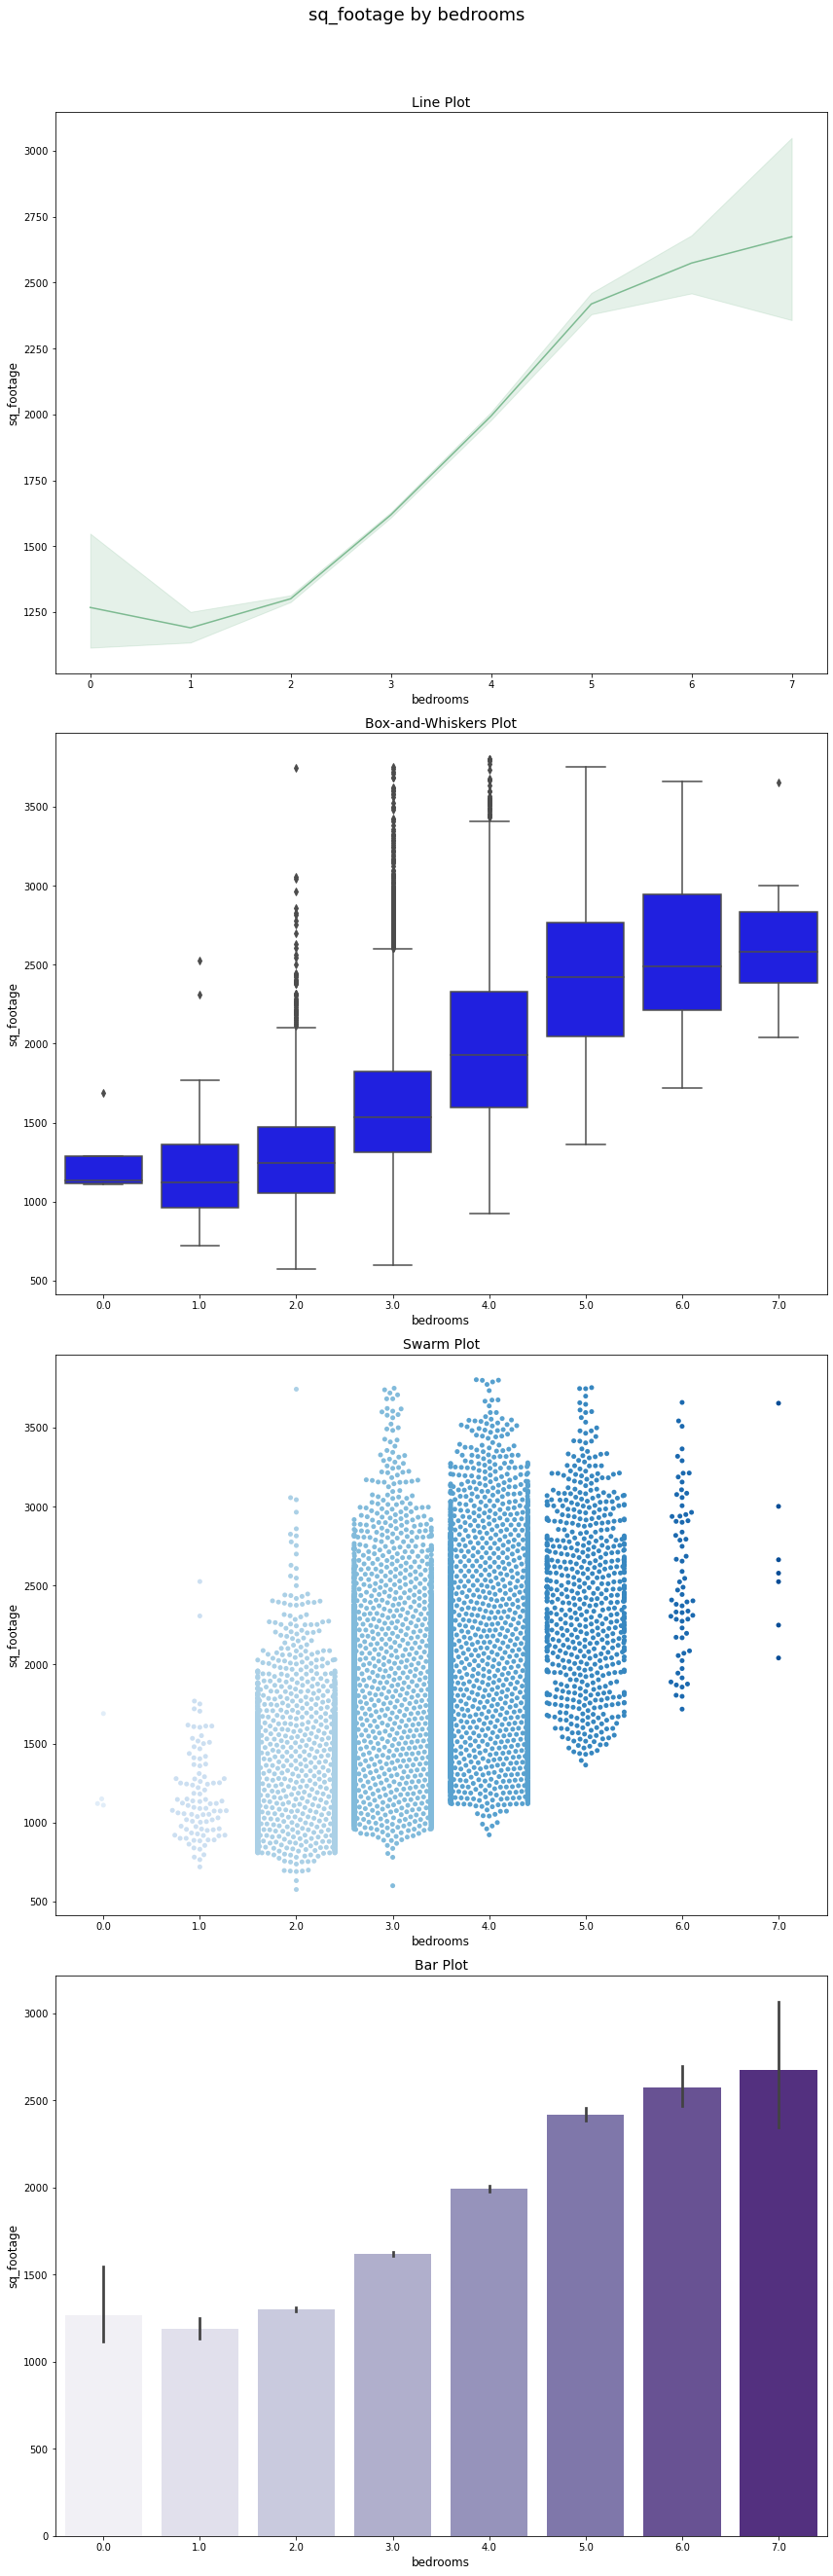

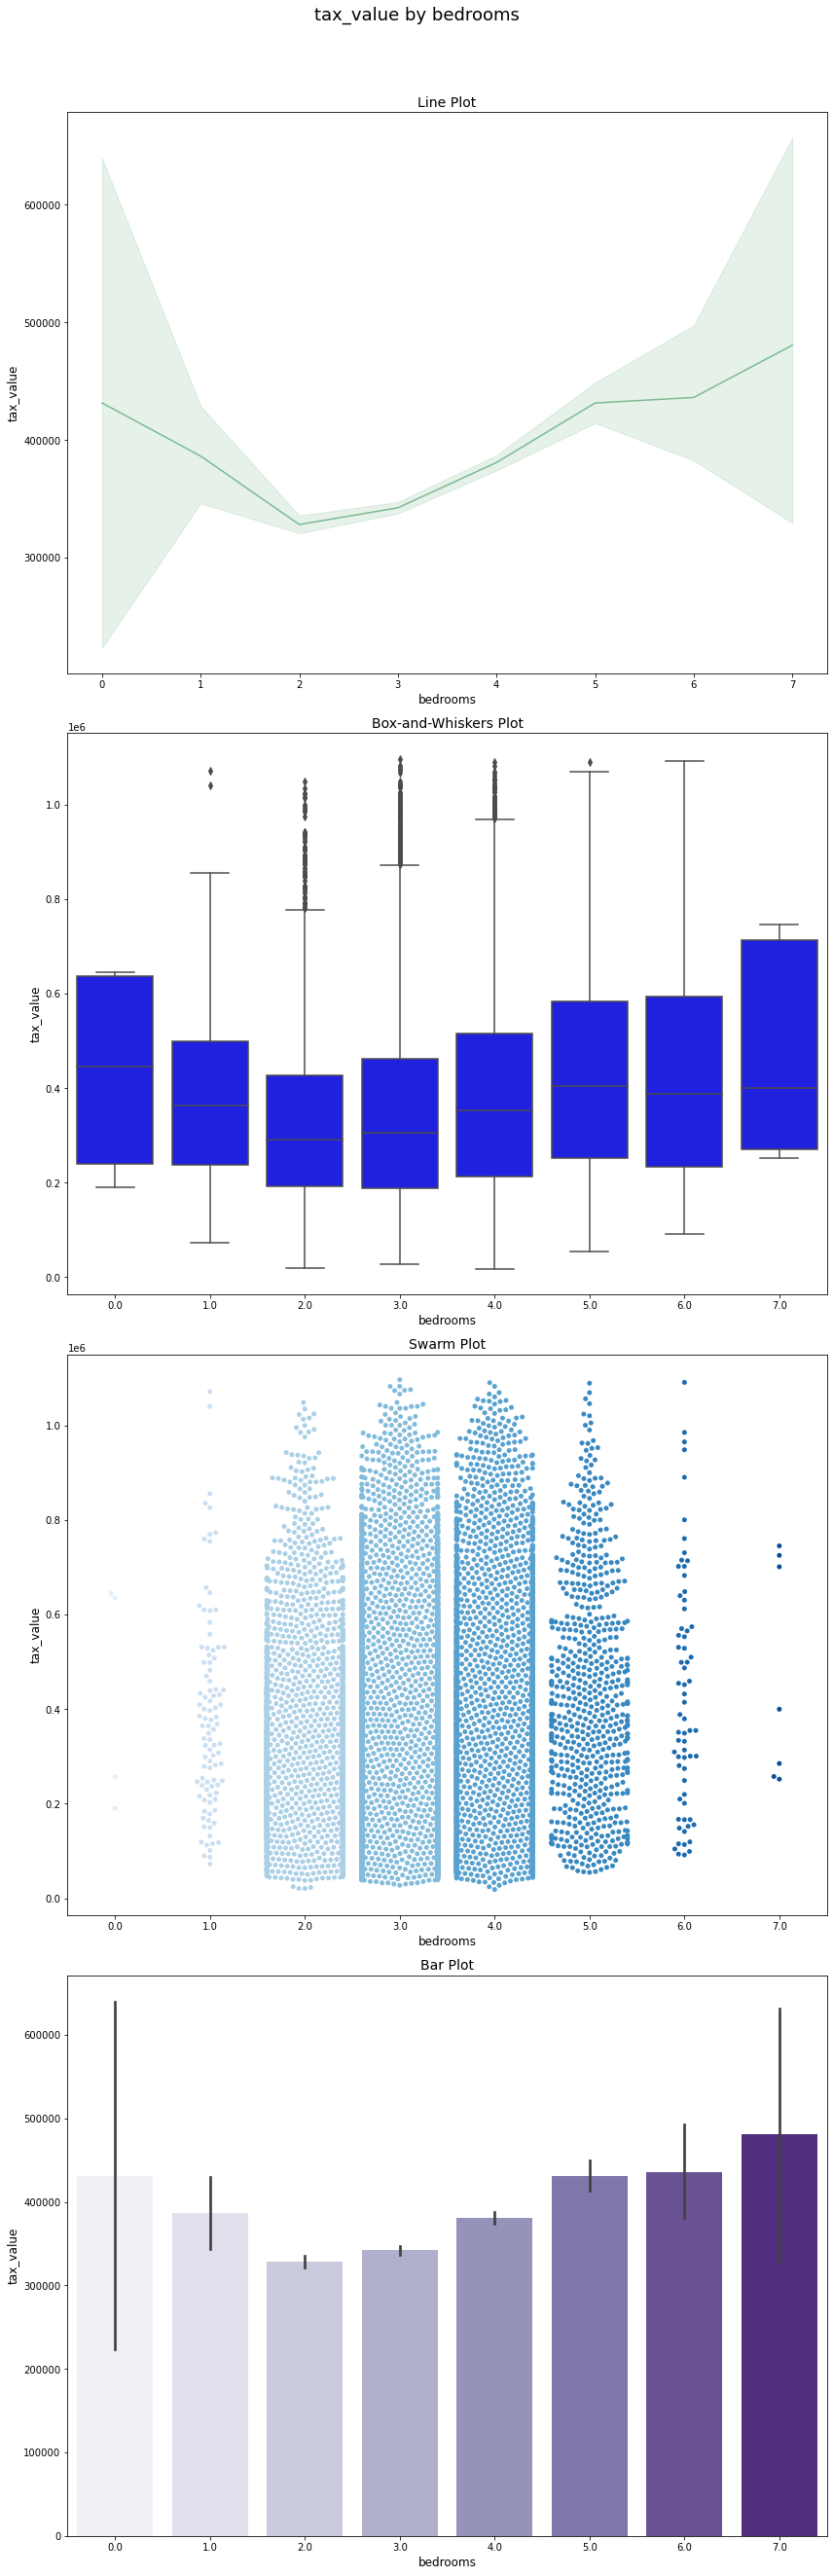

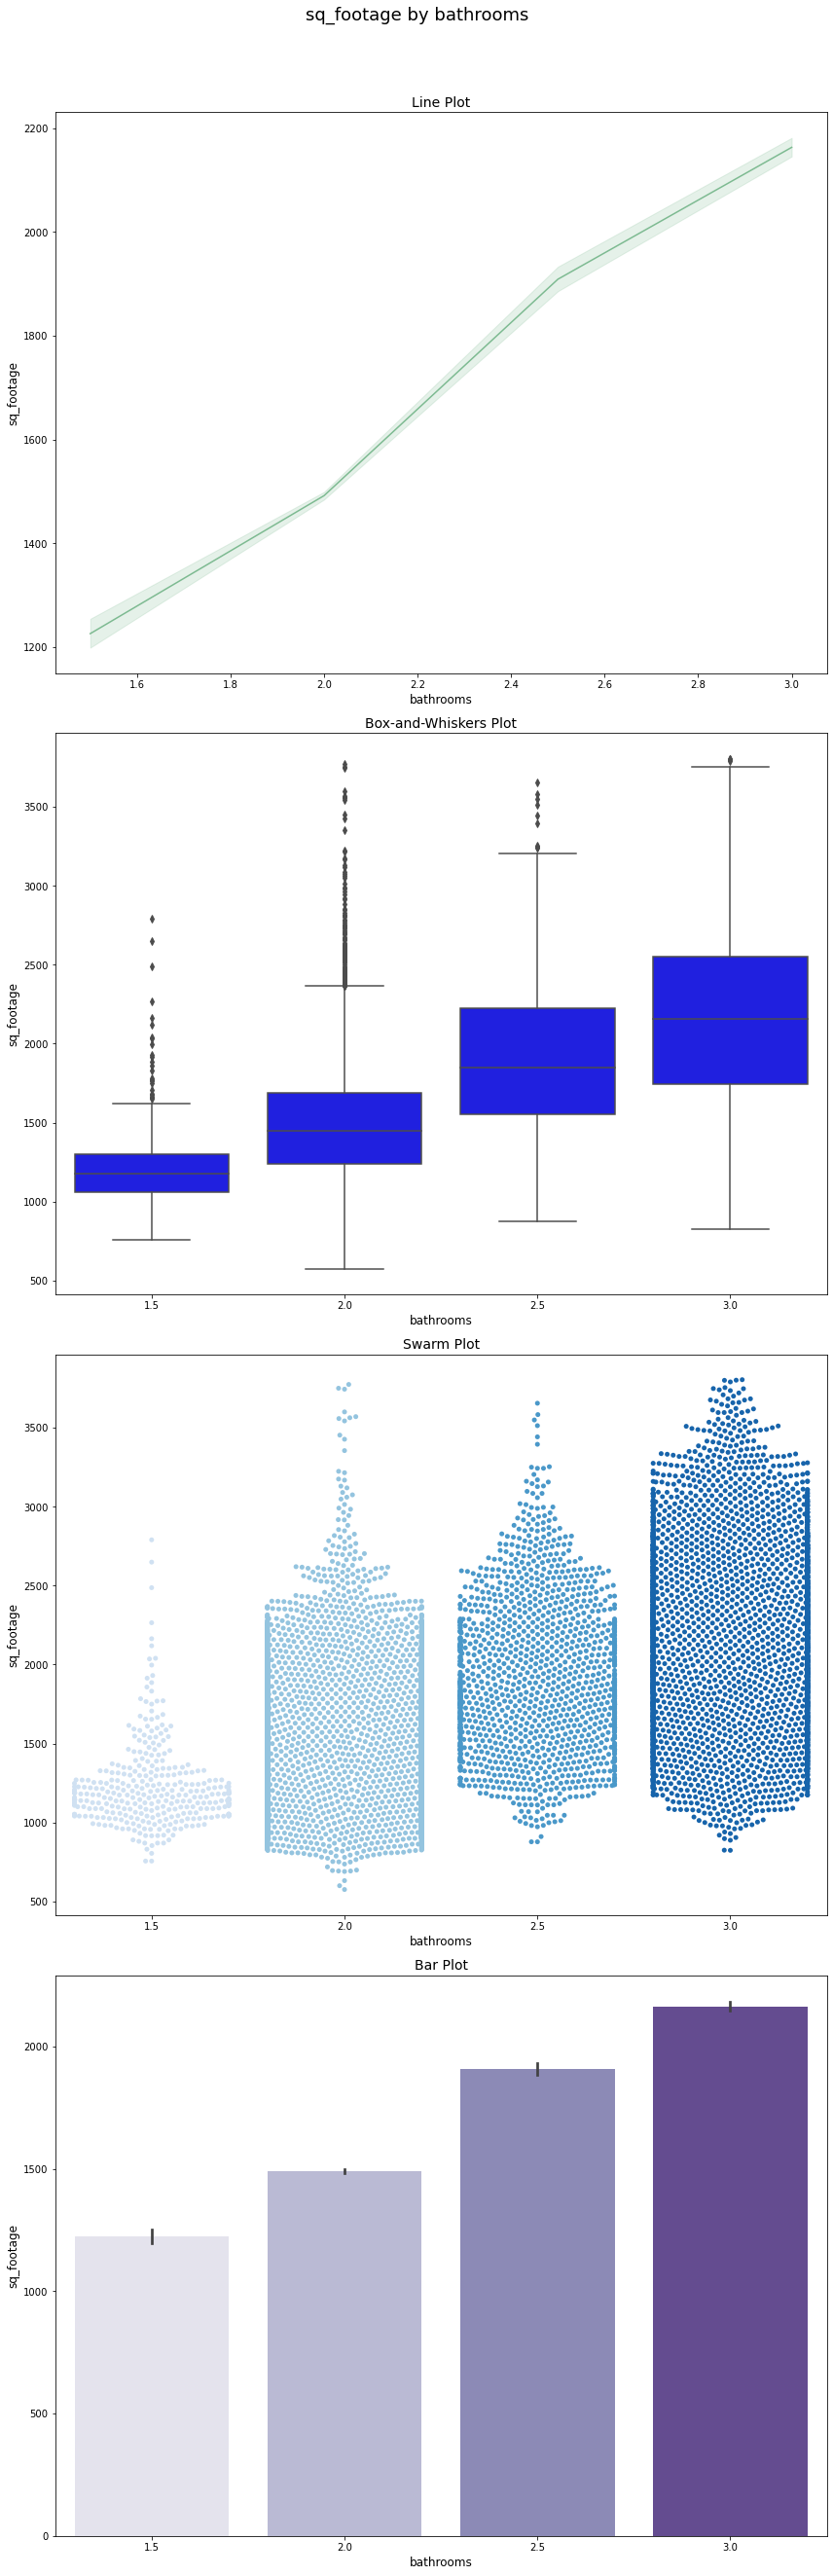

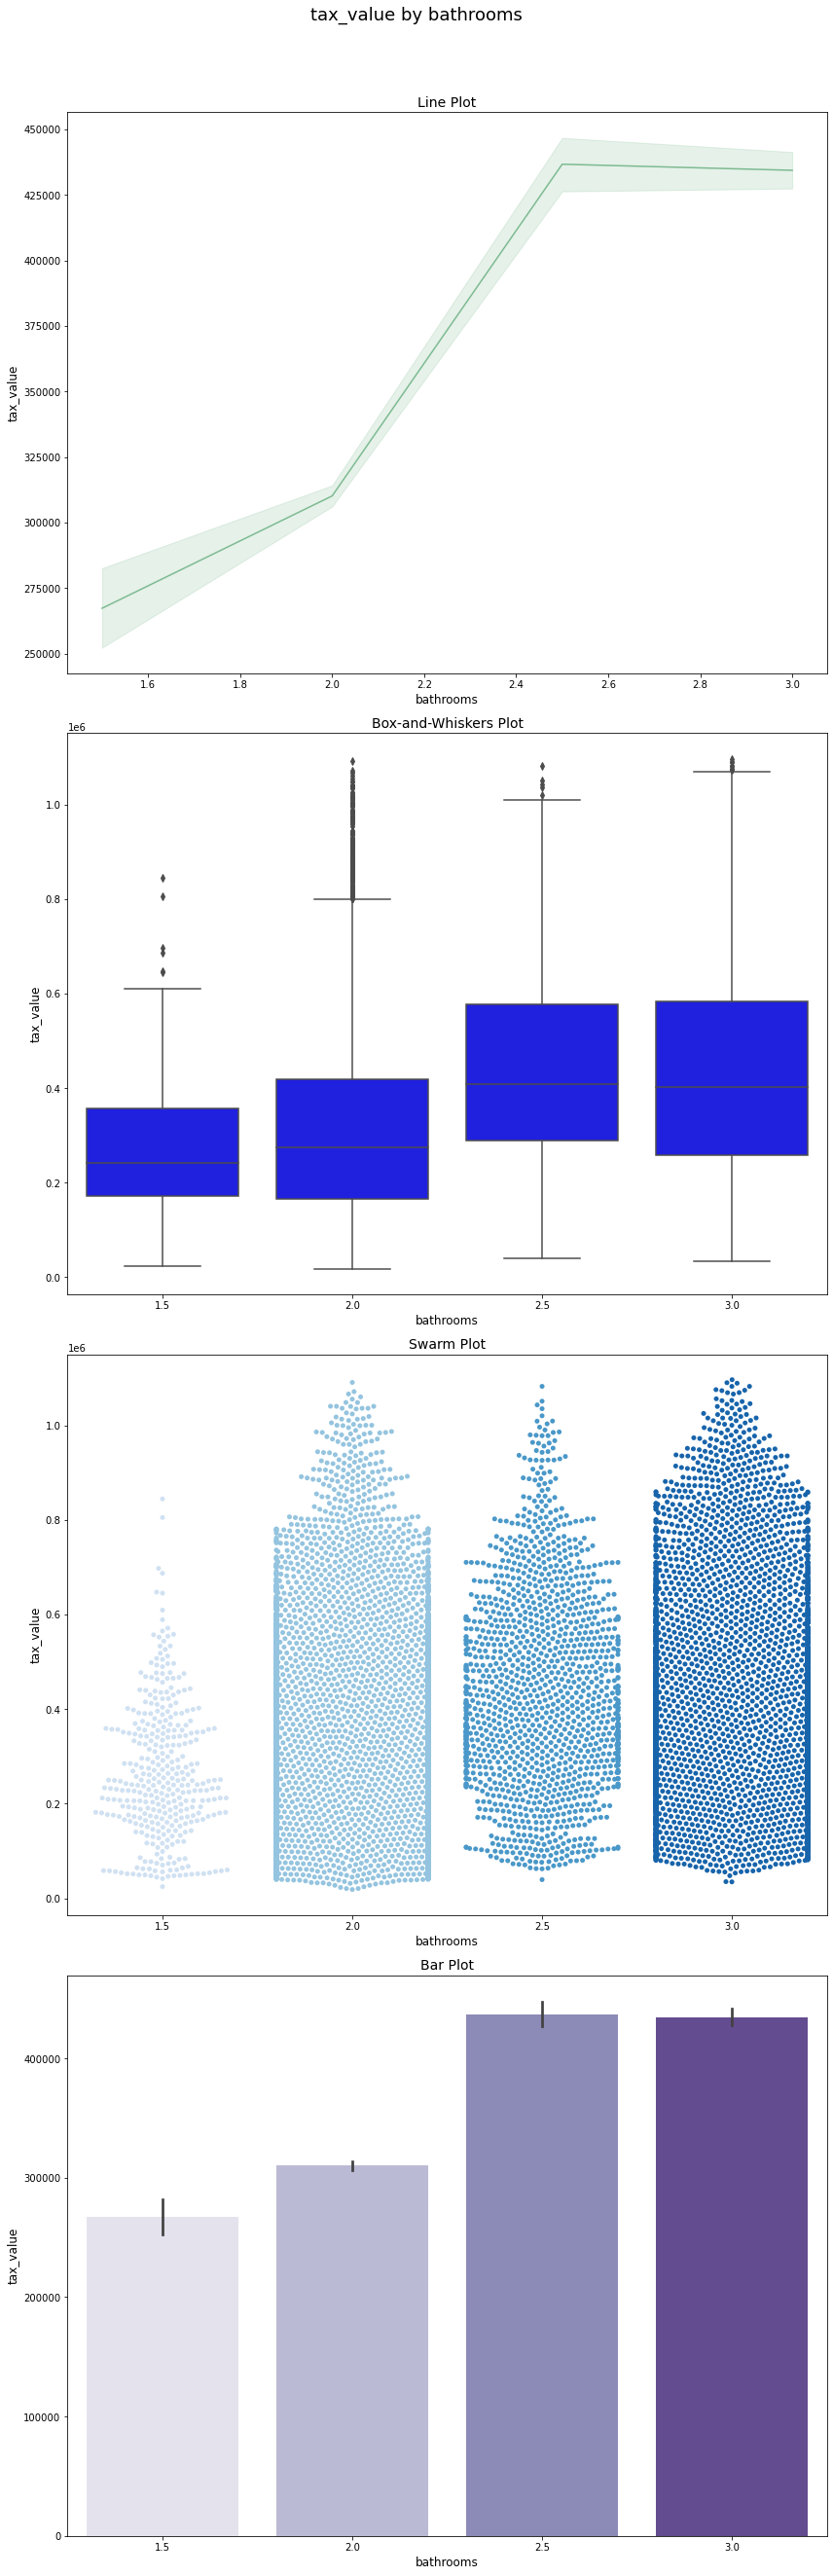

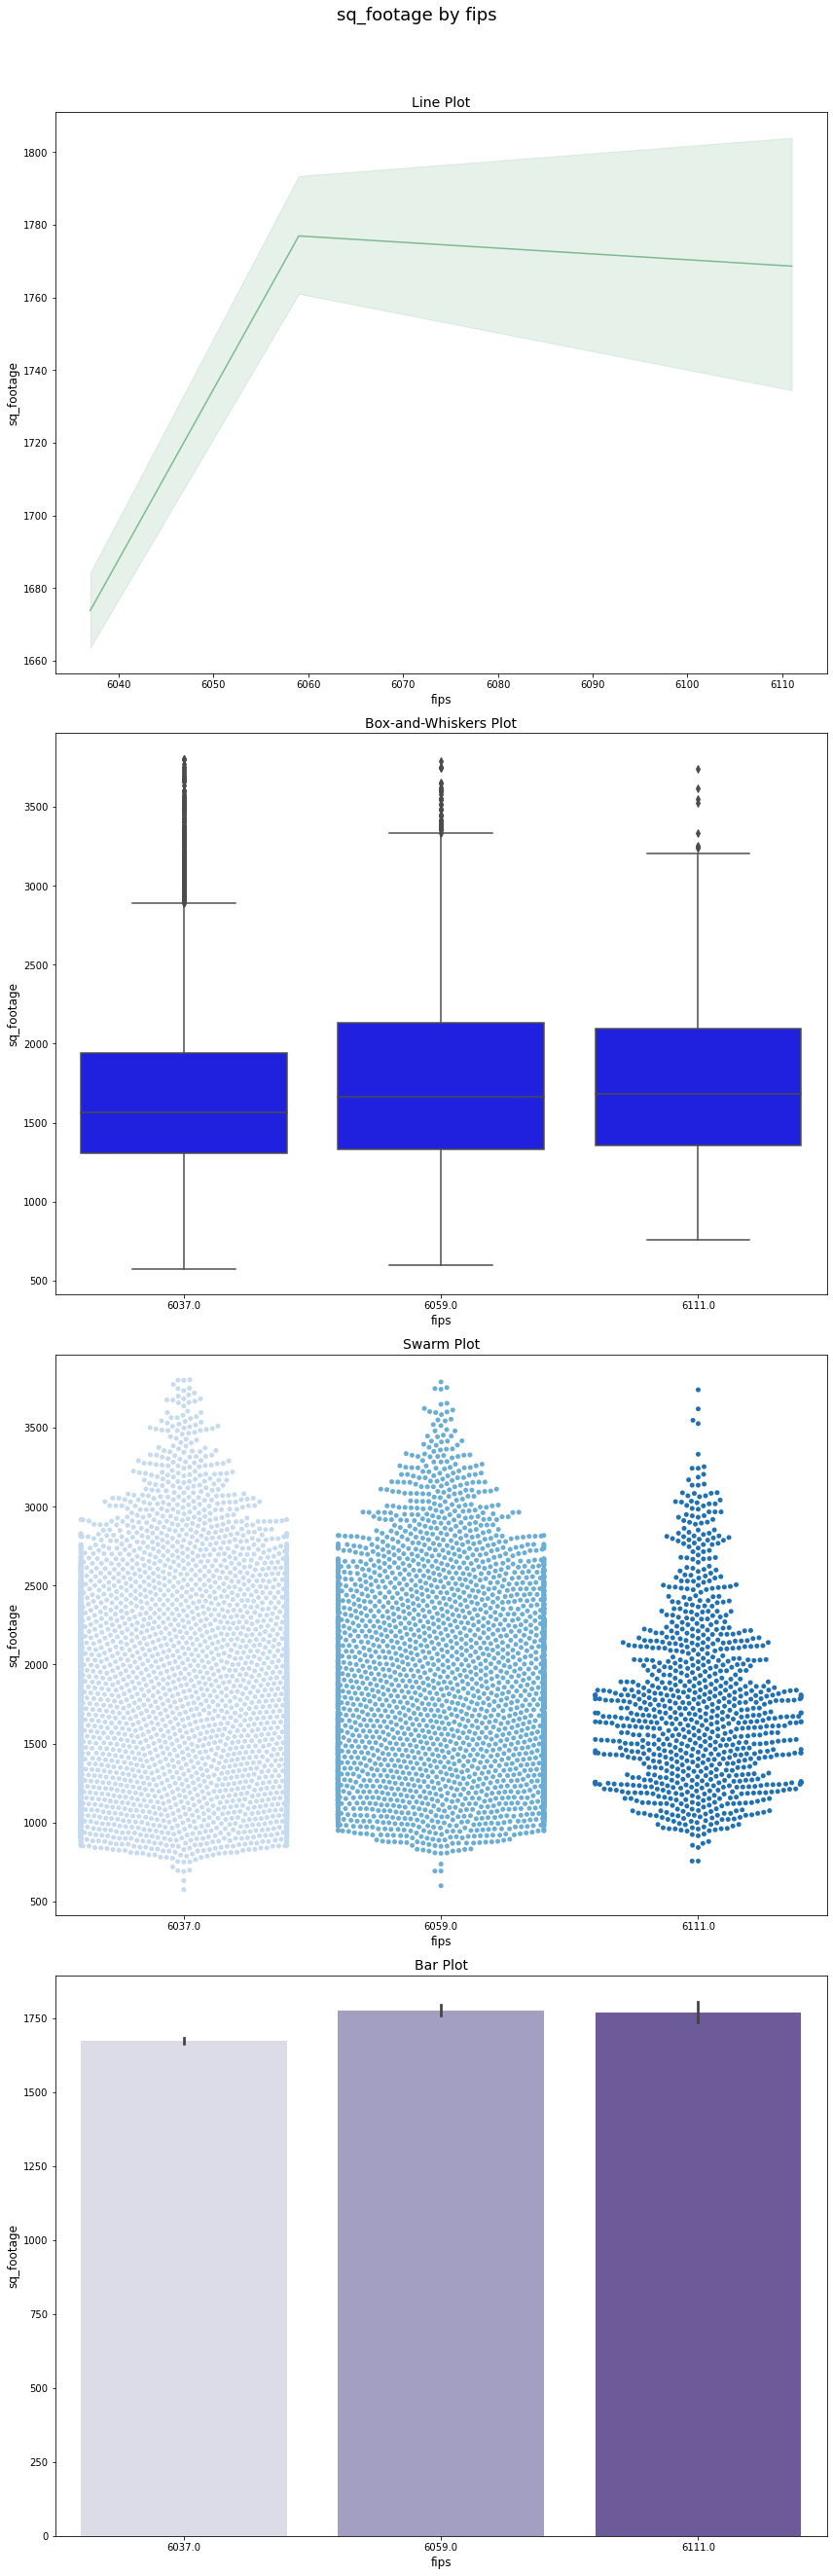

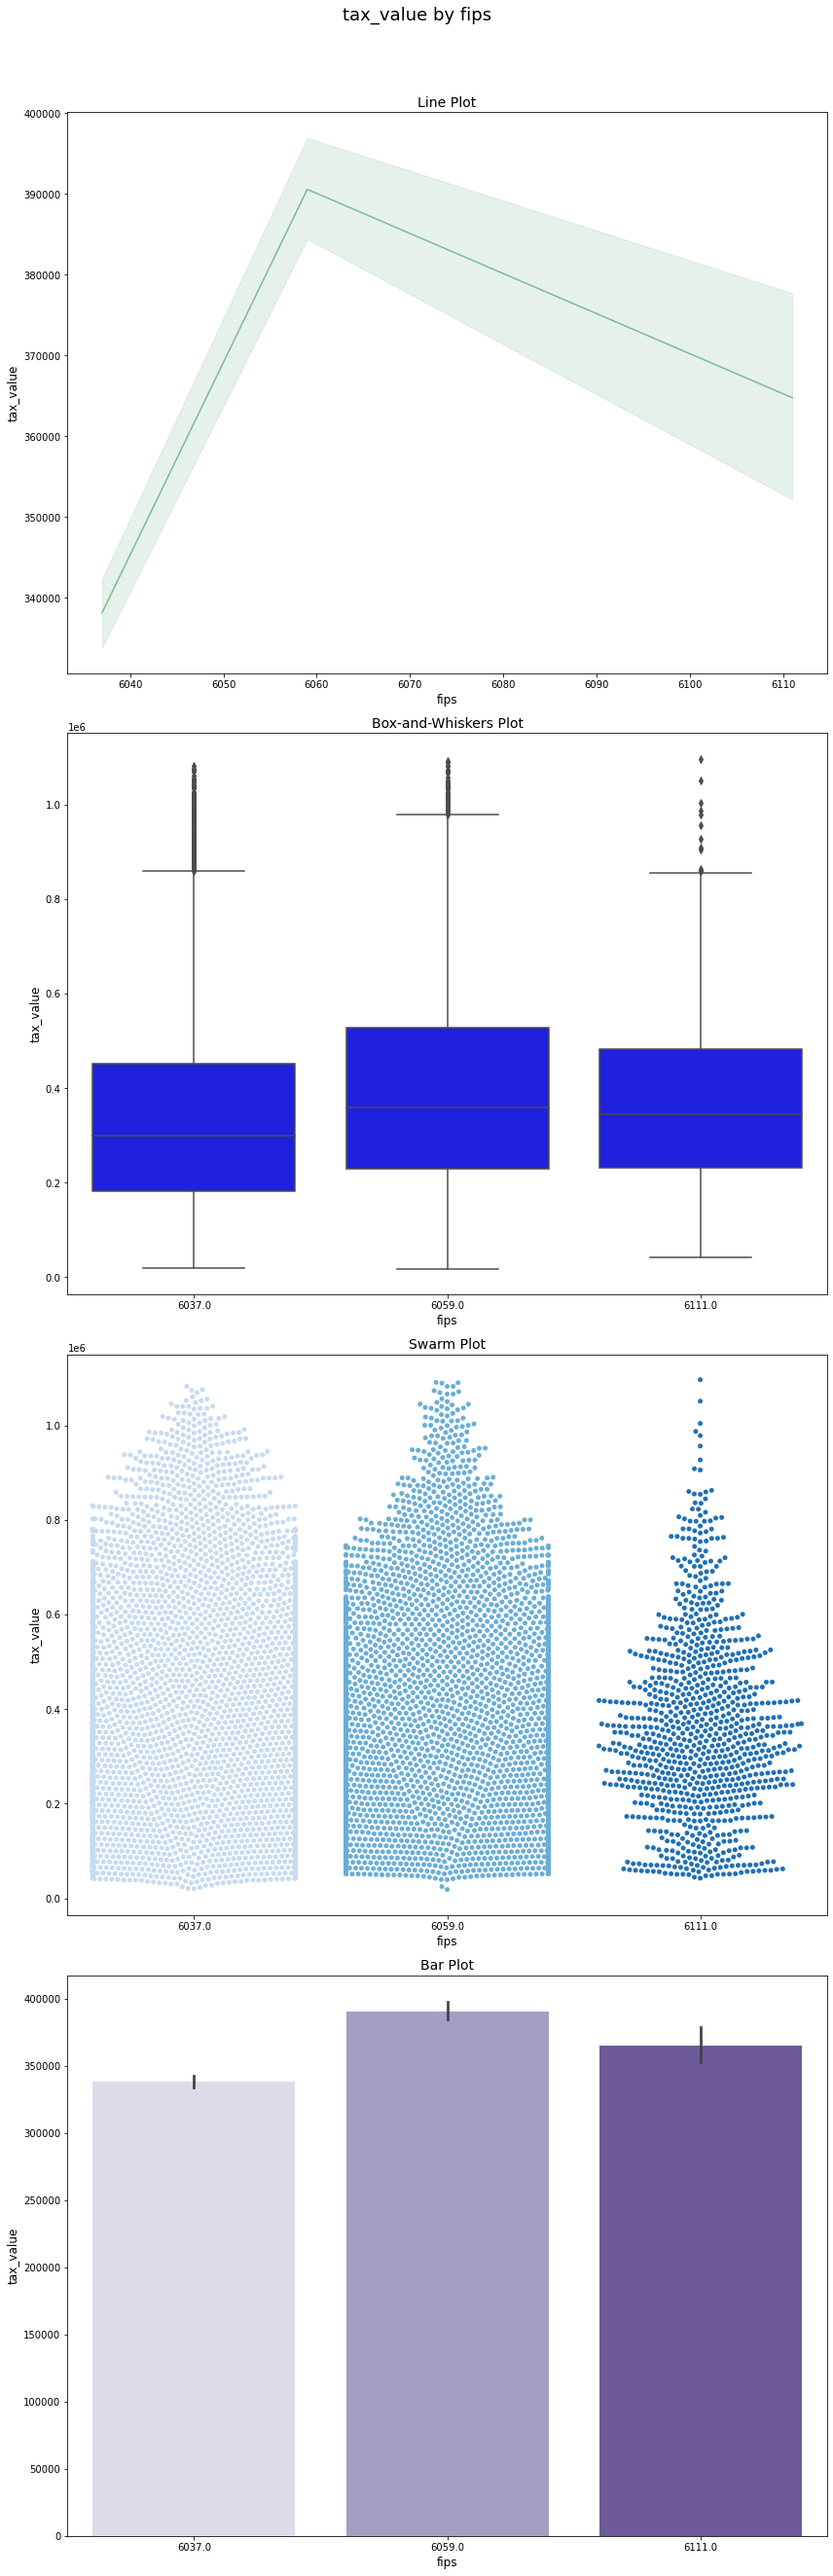

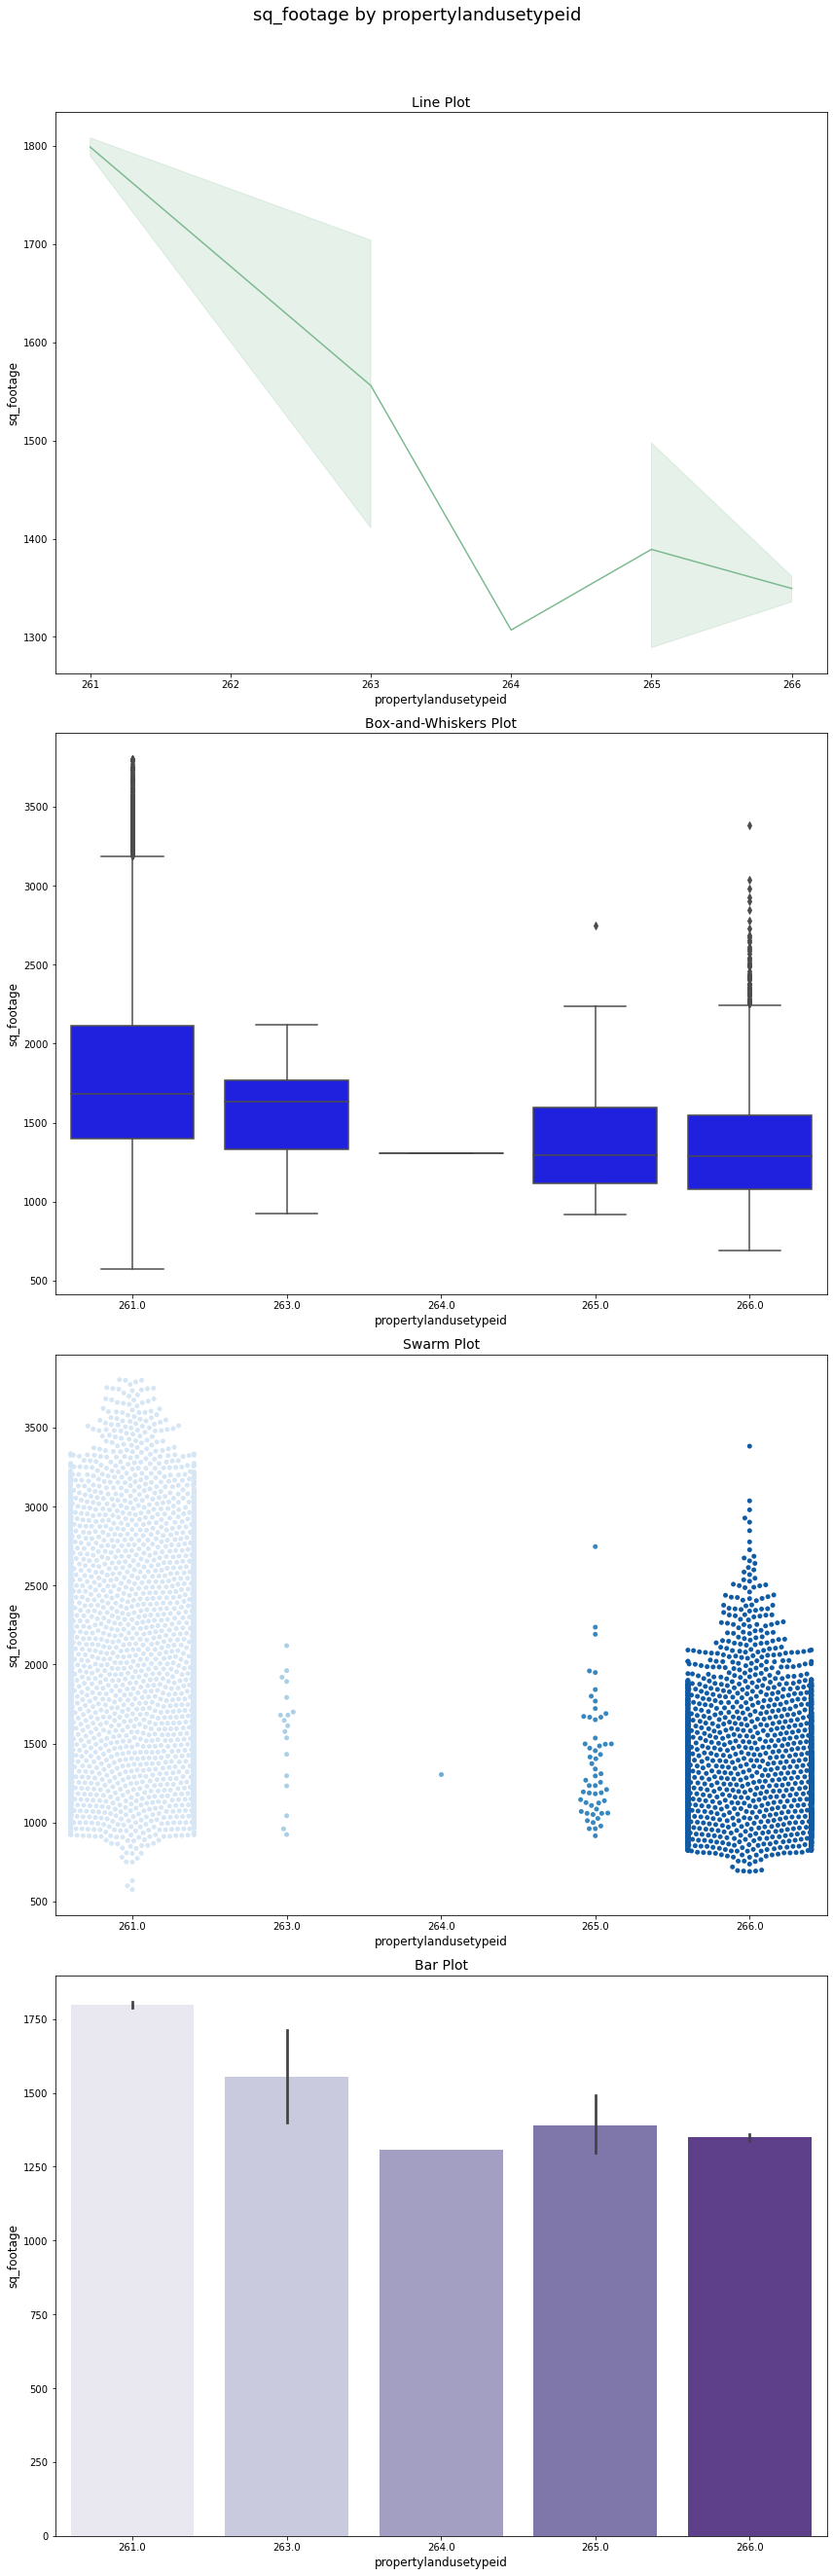

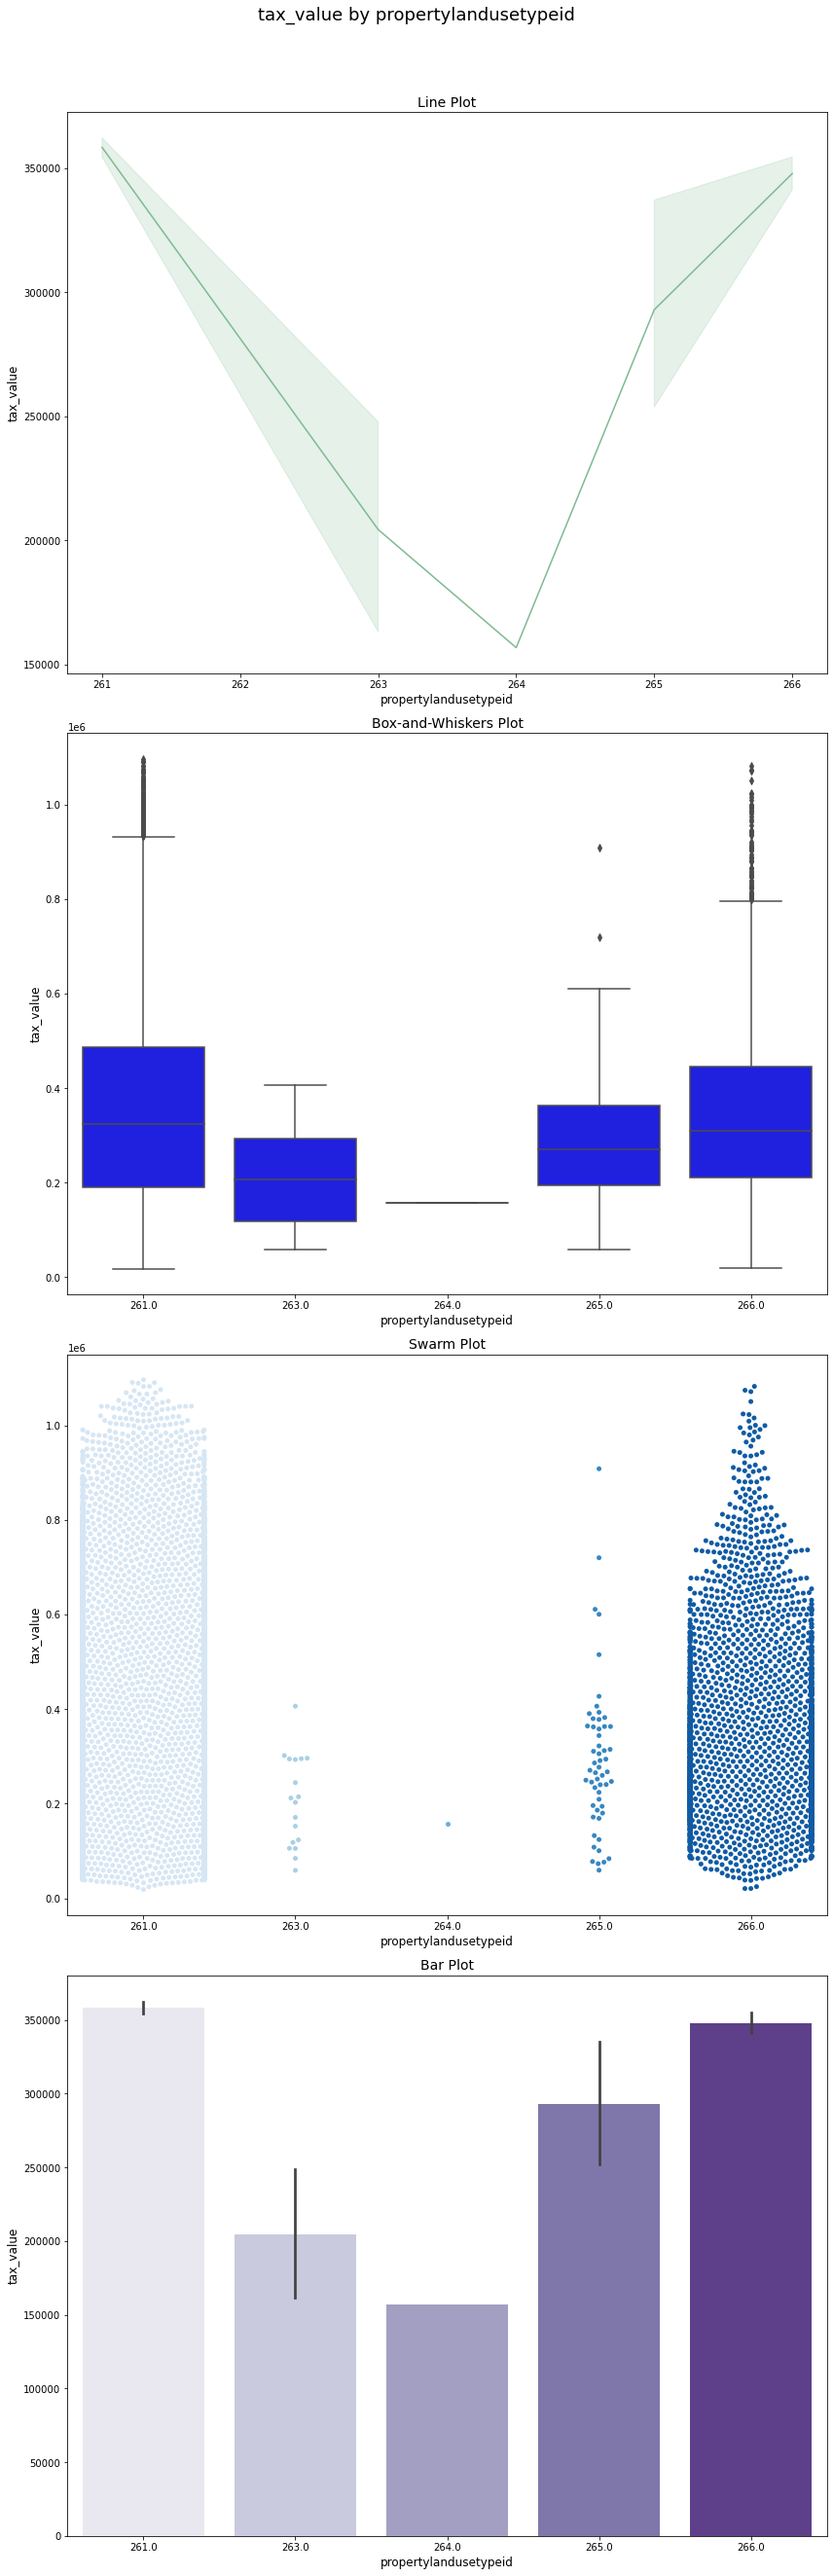

In [32]:
plot_categorical_and_continuous_vars(categorical_vars, continuous_vars, train, descriptive=None)

In [ ]:
sns.lmplot(x="sq_footage", y="tax_value", data=train, line_kws={'color': 'red'})
plt.show()

In [ ]:
explore_univariate(train, categorical_vars, continuous_vars)

In [ ]:
cont_vars = ['sq_footage','taxamount','tax_value']
cat_vars = ['bathrooms', 'fips', 'yr_built']
explore_bivariate(train, 'bedrooms', cat_vars, cont_vars)

**Target Variable/y**

This helps us determine which type of algorithm we may want to use. 

In [ ]:
# how do we determine distribution?
plt.hist(y_train)
plt.title('Distribution of Target(Tax Value)')
plt.show()

In [ ]:
len(y_train)

## Modeling

### Baseline

About the initial baseline: 

> Before we begin making models, we need to know how well we can estimate (predict) the final price (tax_value) without using any features. This is often done by predicting every observation's target value to be the mean or the median. E.g. we could predict every price to be the mean price of all the properties in our training sample. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat. 


1. Predict all prices to be $363,845.89, which is equal to the mean of tax_value for the training sample. Store in `y_train['price_pred_mean']`. 

2. Predict all final grades to be $328,010.00, which is equal to the median of tax_value  for the training sample. Store in `y_train['price_pred_median']`.  

3. Compute the RMSE comparing actual final price (tax_value) to price_pred_mean. 

4. Compute the RMSE comparing actual final grade (tax_value) to price_pred_median. 

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_train.head()

In [ ]:
y_validate.head()

In [ ]:
# 1. Predict price_pred_mean
price_pred_mean = y_train.tax_value.mean()
y_train['price_pred_mean'] = price_pred_mean
y_validate['price_pred_mean'] = price_pred_mean

In [ ]:
round(price_pred_mean,2)

In [ ]:
# 2. compute price_pred_median
price_pred_median = y_train.tax_value.median()
y_train['price_pred_median'] = price_pred_median
y_validate['price_pred_median'] = price_pred_median

round(price_pred_median,2)

In [ ]:
# 3. RMSE of price_pred_mean
rmse_train = mean_squared_error(y_train.tax_value,
                                y_train.price_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_mean) ** (1/2)

In [ ]:
rmse_train_2 = mean_squared_error(y_train.tax_value,
                                y_train.price_pred_mean, squared = False)
rmse_validate_2 = mean_squared_error(y_validate.tax_value, y_validate.price_pred_mean, squared = False)

In [ ]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

In [ ]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_2, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_2, 2))

In [ ]:
# 4. RMSE of price_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


#### Addendum/Note:
we will incrementally build 
a dataframe for comparison of 
our metrics for model selection
for ease of reflection

In [34]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [ ]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train.tax_value,
                           y_train.price_pred_median,
                           'median_baseline',
                          metric_df)

In [ ]:
metric_df

In [ ]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Prices")
plt.hist(y_train.price_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Final Price - Mean")
plt.hist(y_train.price_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Prices - Median")
plt.xlabel("Final Price (Tax Value)")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

### LinearRegression (OLS)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final price for properties in training sample using our model (lm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [ ]:
y_train.head()

In [ ]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

In [ ]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train, y_train.tax_value)

In [ ]:
# predict train
# 
# use the thing!
# 
y_train['price_pred_lm'] = lm.predict(X_train)

In [ ]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lm) ** (1/2)

# predict validate
y_validate['price_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.price_pred_lm)}, ignore_index=True)

In [ ]:
metric_df

### LassoLars

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for students in training sample using our model (lars). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['price_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lars) ** (1/2)

# predict validate
y_validate['price_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.price_pred_lars,
               'lasso_alpha_1',
               metric_df)

In [ ]:
metric_df

### Trying a higher alpha translates into a higher RMSE. Sticking with alpha = 1 for lower RMSE.

In [ ]:
# create the model object
lars = LassoLars(alpha=4)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['price_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lars) ** (1/2)

# predict validate
y_validate['price_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

### TweedieRegressor (GLM)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final price for properties in training sample using our model (glm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [ ]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['price_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_glm) ** (1/2)

# predict validate
y_validate['price_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
make_metric_df(y_validate.tax_value,
               y_validate.price_pred_glm,
               'glm_poisson',
               metric_df)

In [ ]:
### Using a different power to try the fit to a different distribution

In [ ]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['price_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_glm) ** (1/2)

# predict validate
y_validate['price_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

1. Create the new features, based on value indicated for degree for train, validate & test. 

2. Fit the Linear Regression model

3. Predict using the transformed (squared or cubed, e.g.) features 

4. Evaluate using RMSE

5. Repeat predictions and evaluation for validation.

6. Compare RMSE train vs. validation. Overfitting?

## **PolynomialFeatures**

In [ ]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

## **LinearRegression**

In [ ]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['price_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.price_pred_lm2) ** (1/2)

# predict validate
y_validate['price_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.price_pred_lm2) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [ ]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.price_pred_lm2,
               'quadratic',
               metric_df)

In [ ]:
metric_df

### Evaluate

**Plotting Actual vs. Predicted Values**

In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.price_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.price_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.price_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.price_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Price")
plt.ylabel("Predicted Final Price")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Residual Plots: Plotting the Errors in Predictions**

In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.price_pred_lm - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.price_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.price_pred_lm2 - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Residual/Error: Predicted Grade - Actual Grade")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Histograms**

In [ ]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Final Prices")
plt.hist(y_validate.price_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.price_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.price_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Final Price (Tax Value)")
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual Grades to Distributions of Predicted Grades for the Top Models")
plt.legend()
plt.show()

In [ ]:
# Comparing models DF:

In [ ]:
metric_df

**Model Selection & Out-of-Sample Evaluation**

Model selected: lm (using LinearRegression)

In [ ]:
#y_test = pd.DataFrame(y_test)

# predict on test
#y_test['price_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
#rmse_test = mean_squared_error(y_test.tax_value, y_test.price_pred_lm) ** (1/2)

#print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)